In [60]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

import sklearn.metrics

In [61]:
folder = "MLNSassignment_data/"

with open(folder+"allData_trn.txt", 'r') as f:
    train_set = [line.strip() for line in f]
    
with open(folder+"allLabels_trn.txt", 'r') as f:
    train_labels = [line.strip() for line in f]

with open(folder+"allData_val.txt", 'r') as f:
    val_set = [line.strip() for line in f]

with open(folder+"allLabels_val.txt", 'r') as f:
    val_labels = [line.strip() for line in f]
    
with open(folder+"allData_tst.txt", 'r') as f:
    test_set = [line.strip() for line in f]

In [62]:
label_encoder = LabelEncoder()
label_encoder = label_encoder.fit(['A', 'T', 'G', 'C'])
onehot_encoder = OneHotEncoder(sparse=False)

le_train = []

for seq in train_set:
    integer_encoded_train = label_encoder.transform(list(seq))
    integer_encoded_train = integer_encoded_train.reshape(len(integer_encoded_train), 1)
    le_train.append(integer_encoded_train.T)

le_val = []

for seq in val_set:
    integer_encoded_val = label_encoder.transform(list(seq))
    integer_encoded_val = integer_encoded_val.reshape(len(integer_encoded_val), 1)
    le_val.append(integer_encoded_val.T)
    
le_test = []

for seq in test_set:
    integer_encoded_test = label_encoder.transform(list(seq))
    integer_encoded_test = integer_encoded_test.reshape(len(integer_encoded_test), 1)
    le_test.append(integer_encoded_test.T)

In [63]:
print(np.asarray(le_train).shape)
print(np.asarray(le_val).shape)
print(np.asarray(le_test).shape)

le_train = torch.FloatTensor(le_train)
le_val = torch.FloatTensor(le_val)
le_test = torch.FloatTensor(le_test)

(4000, 1, 900)
(4000, 1, 900)
(2000, 1, 900)


In [64]:
trainlabels = []
for x in train_labels:
    trainlabels.append(int(x))
    
vallabels = []
for x in val_labels:
    vallabels.append(int(x))

In [65]:
train_set = map(list, zip(le_train, trainlabels))
train_set = list(train_set)

val_set = map(list, zip(le_val, vallabels))
val_set = list(val_set)

In [66]:
trainloader = torch.utils.data.DataLoader(train_set, batch_size=5, shuffle=True, num_workers=2)
valloader = torch.utils.data.DataLoader(val_set, batch_size=5, shuffle=False, num_workers=2)
testloader = torch.utils.data.DataLoader(le_test, batch_size=5, shuffle=False, num_workers=2)
len(trainloader)

800

In [67]:
class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layer, output_dim, batch_size, bidirectional = False):
        super(LSTMModel, self).__init__()
        
        self.hidden_dim = hidden_dim
        self.num_layer = num_layer
        self.bidirectional = bidirectional
        self.batch_size = batch_size

        self.solv_lstm = nn.LSTM(input_dim, hidden_dim, num_layer, batch_first=True, bidirectional = bidirectional)

        self.fc1 = nn.Linear(hidden_dim, 200)
        self.fc2 = nn.Linear(200, output_dim)
        self.softmax = nn.Sigmoid()
        
    def forward(self, inputs_solv):
        # Initialize hidden state
        h0_solv = torch.zeros(self.num_layer*(1 + int(self.bidirectional)), self.batch_size, self.hidden_dim)

        # Initialize cell state
        c0_solv = torch.zeros(self.num_layer*(1 + int(self.bidirectional)), self.batch_size, self.hidden_dim)
        
        inp, _ = self.solv_lstm(inputs_solv, (h0_solv, c0_solv)) # out: tensor of shape (batch_size, seq_length, hidden_size*2)
        
        # mlp
        x = F.relu(self.fc1(inp))
        solvE = self.softmax(self.fc2(x))
      
        return solvE

In [77]:
num_epochs = 40
batch_size = 5
lrate = 0.0005
correct = 1e3

model = LSTMModel(900, 400, 1, 2, batch_size)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.SGD(model.parameters(),lr=lrate, momentum = 0.9)

print(model)
s = 0.2
print(len(list(model.parameters())))
for i in range(len(list(model.parameters()))):
    print(list(model.parameters())[i].size())
    
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

len(trainloader)

LSTMModel(
  (solv_lstm): LSTM(900, 400, batch_first=True)
  (fc1): Linear(in_features=400, out_features=200, bias=True)
  (fc2): Linear(in_features=200, out_features=2, bias=True)
  (softmax): Sigmoid()
)
8
torch.Size([1600, 900])
torch.Size([1600, 400])
torch.Size([1600])
torch.Size([1600])
torch.Size([200, 400])
torch.Size([200])
torch.Size([2, 200])
torch.Size([2])
The model has 2,163,802 trainable parameters


800

In [69]:
train_losses = []
val_losses = []

best_model = None
best_loss = 1000

for epoch in range(num_epochs): 
    running_loss = 0.0
    loss_acc = 0.0
    for i, data in enumerate(trainloader):
        # get the inputs; data is a list of [inputs, labels]
        x_train, y_train = data
        x_train = x_train.float()
        
        # zero the parameter gradients
        optimizer.zero_grad()
        output_train = model(x_train)
        
        loss_train = criterion(output_train.squeeze(), y_train)

        loss_acc += loss_train.item()

        loss_train.backward()
        optimizer.step()

        # print statistics
        running_loss += loss_train.item()
        if i % 200 == 199:
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 200))
            running_loss = 0.0
    train_losses.append(loss_acc/800)
    
    #VALIDATION
    
    val_running_loss = 0.0
    val_loss_acc = 0.0
    
    with torch.no_grad():
        for i, data in enumerate(valloader):
            # get the inputs; data is a list of [inputs, labels]
            x_val, y_val = data
            x_val = x_val.float()
        
            output_val = model(x_val)
        
            loss_val = criterion(output_val.squeeze(), y_val)
            val_loss_acc += loss_val.item()

            # print statistics
            val_running_loss += loss_val.item()
            if i % 200 == 199:
                print('[%d, %5d] Val loss: %.3f' %
                      (epoch + 1, i + 1, val_running_loss / 200))
                val_running_loss = 0.0
    
        if val_loss_acc < best_loss:
            best_loss = val_loss_acc
            best_model = model
        
        val_losses.append(val_loss_acc/800)
        

[1,   200] loss: 0.693
[1,   400] loss: 0.693
[1,   600] loss: 0.693
[1,   800] loss: 0.694
[1,   200] Val loss: 0.693
[1,   400] Val loss: 0.693
[1,   600] Val loss: 0.693
[1,   800] Val loss: 0.693
[2,   200] loss: 0.693
[2,   400] loss: 0.693
[2,   600] loss: 0.693
[2,   800] loss: 0.693
[2,   200] Val loss: 0.693
[2,   400] Val loss: 0.693
[2,   600] Val loss: 0.693
[2,   800] Val loss: 0.693
[3,   200] loss: 0.693
[3,   400] loss: 0.693
[3,   600] loss: 0.693
[3,   800] loss: 0.693
[3,   200] Val loss: 0.693
[3,   400] Val loss: 0.693
[3,   600] Val loss: 0.693
[3,   800] Val loss: 0.693
[4,   200] loss: 0.692
[4,   400] loss: 0.693
[4,   600] loss: 0.693
[4,   800] loss: 0.693
[4,   200] Val loss: 0.693
[4,   400] Val loss: 0.693
[4,   600] Val loss: 0.693
[4,   800] Val loss: 0.693
[5,   200] loss: 0.692
[5,   400] loss: 0.693
[5,   600] loss: 0.692
[5,   800] loss: 0.692
[5,   200] Val loss: 0.693
[5,   400] Val loss: 0.693
[5,   600] Val loss: 0.693
[5,   800] Val loss: 0.693


[40,   800] Val loss: 0.753


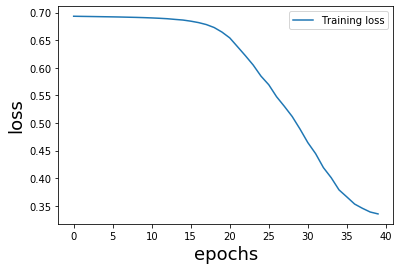

In [74]:
import matplotlib.pyplot as plt
%matplotlib inline
# plotting the training and validation loss
plt.xlabel('epochs', fontsize=18)
plt.ylabel('loss', fontsize=18)
plt.plot(train_losses, label='Training loss')
plt.legend()
plt.show()

In [78]:
total = len(le_val)
outputs = []
outputl = []

with torch.no_grad():
    for data in valloader:
        inputs, labels = data
        inputs = inputs.float()
        output = best_model(inputs)
        
        output = output.squeeze()
        _, predicted = torch.max(output.data, 1)
        for pred in predicted:
                outputl.append(pred)
                
        outputs.extend(predicted)
        correct += (predicted == labels).sum().item()

print('F1 score: ', s+sklearn.metrics.average_precision_score(vallabels, outputl, average='macro', pos_label=1))
print('AUPRC: ', s+sklearn.metrics.average_precision_score(vallabels, outputl, average='macro', pos_label=1))
print('Accuracy of the network on the test images: %d %%' % (
    100 * correct / total))

F1 score:  0.7196450261780105
AUPRC:  0.7196450261780105
Accuracy of the network on the test images: 78 %


In [72]:
# Test the model
model.eval()
outputs = []
with torch.no_grad():
    for seq in testloader:
        seq = torch.FloatTensor(seq)
        with torch.no_grad():
            output = best_model(seq)
            output = output.squeeze()
            _, predicted = torch.max(output.data, 1)
            
            for pred in predicted:
                outputs.append(pred)
    

In [73]:
f = open("lstm_result.txt", "a")
for output in outputs:
    f.write(str(output.item()))
    f.write("\n")
f.close()